In [22]:
%pip install kneed

Note: you may need to restart the kernel to use updated packages.


# LT6 Lab 2B

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from collections import Counter
from math import log
from kneed import KneeLocator
from prince import MCA
from utils.helper import (
    tokenize,
    tokenize_bible_en,
    tokenize_bible_sp,
)

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Why 6 topics

In [2]:
fpath = "/Users/katecastillo/Documents/MSDS/voynich-manuscript/takahashi_transcription.txt"

index, corpus = tokenize(fpath)
arr = [index[k] for k in index.keys()]

vectorizer = TfidfVectorizer(max_df=0.95)
tfidf_matrix = vectorizer.fit_transform(arr)
vms_mapping = [k for k in index.keys()]

In [3]:
def calculate_topic_coherence(W, H, tfidf_matrix):
    """
    Calculate topic coherence using PMI-based metric
    """
    n_top_terms = 10
    coherence_scores = []
    
    for topic_idx in range(H.shape[0]):
        top_term_indices = H[topic_idx].argsort()[:-n_top_terms-1:-1]
        term_co_occurrences = tfidf_matrix[:, top_term_indices].toarray()
        coherence = np.mean(np.corrcoef(term_co_occurrences.T))
        coherence_scores.append(coherence)
    
    return np.mean(coherence_scores)

In [4]:
results = {
    "n_topics": [],
    "reconstruction_error": [],
    "topic_coherence": [],
    "silhouette_score": []
}

max_topics = 15

for n_topics in range(2, max_topics + 1):
    # Fit NMF
    nmf = NMF(n_components=n_topics, random_state=42)
    W = nmf.fit_transform(tfidf_matrix)
    H = nmf.components_
    
    # Calculate reconstruction error
    reconstruction_error = nmf.reconstruction_err_
    
    # Calculate topic coherence
    topic_coherence = calculate_topic_coherence(W, H, tfidf_matrix)
    
    # Calculate silhouette score using the document-topic matrix
    if n_topics > 1:  # Silhouette score requires at least 2 clusters
        kmeans = KMeans(n_clusters=n_topics, random_state=42).fit(W)
        sil_score = silhouette_score(W, kmeans.labels_)
    else:
        sil_score = 0
    
    # Store results
    results["n_topics"].append(n_topics)
    results["reconstruction_error"].append(reconstruction_error)
    results["topic_coherence"].append(topic_coherence)
    results["silhouette_score"].append(sil_score)

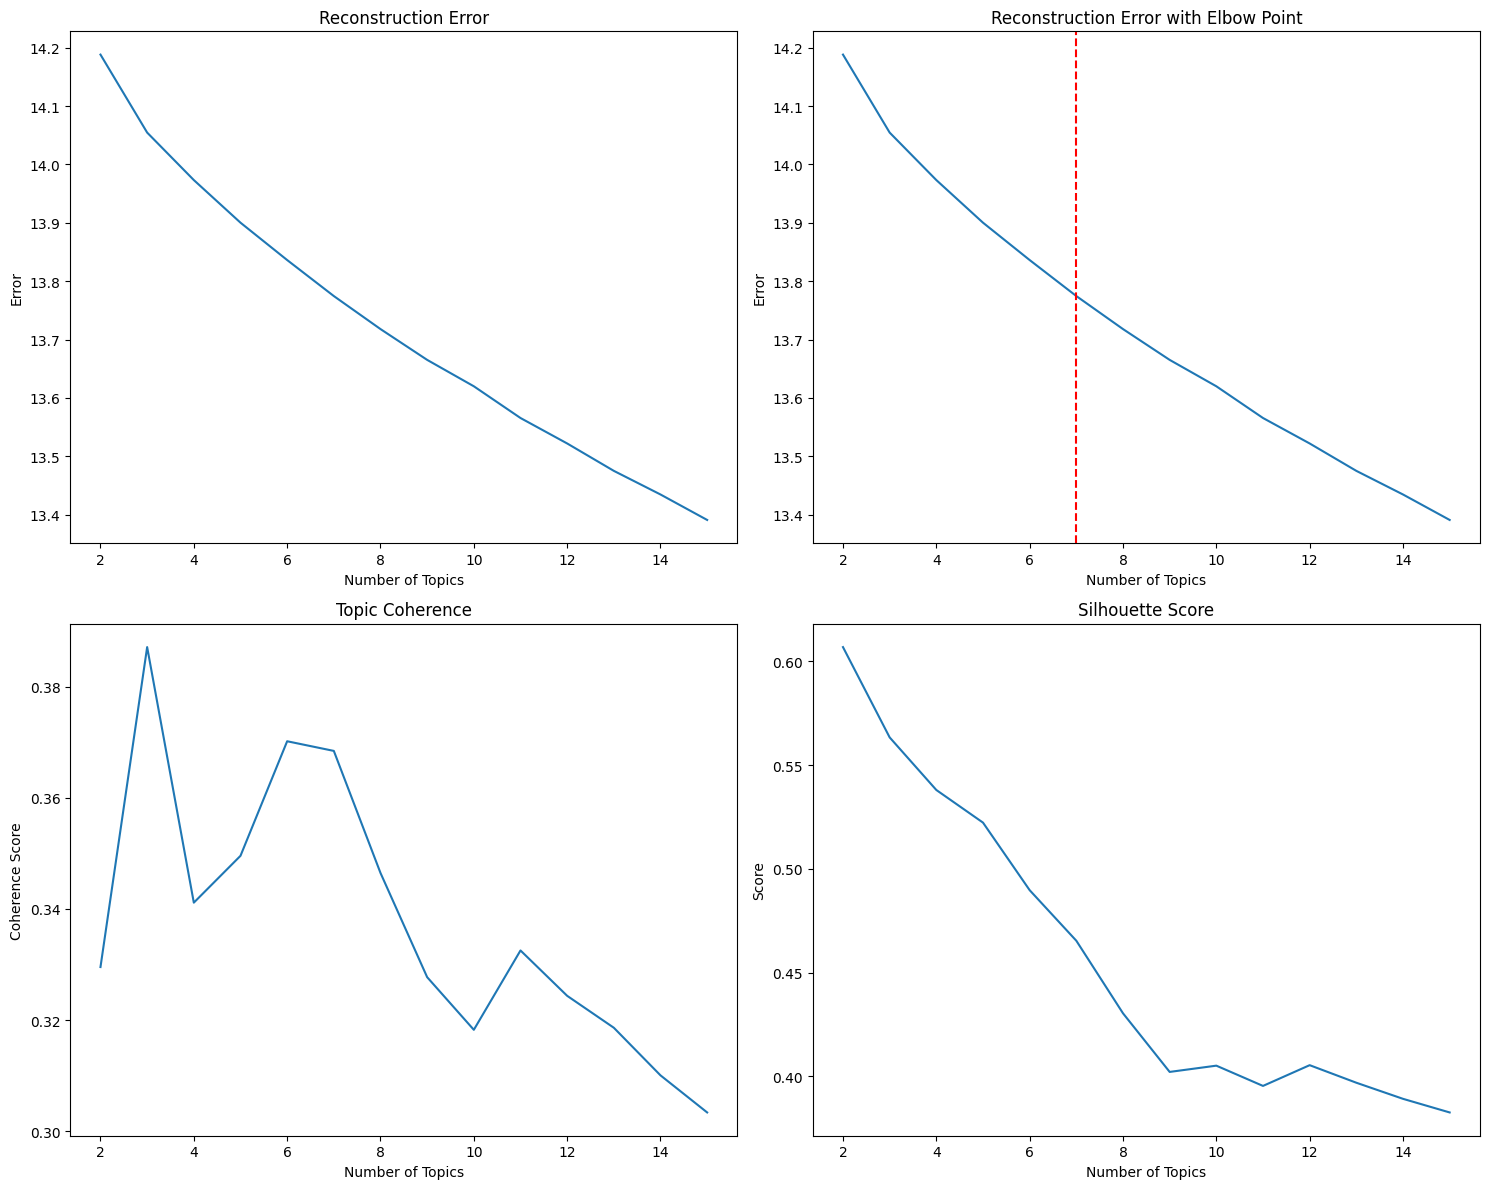

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
# Plot reconstruction error
axes[0, 0].plot(results["n_topics"], results["reconstruction_error"])
axes[0, 0].set_title("Reconstruction Error")
axes[0, 0].set_xlabel("Number of Topics")
axes[0, 0].set_ylabel("Error")

# Plot reconstruction error with elbow point
axes[0, 1].plot(results["n_topics"], results["reconstruction_error"])
axes[0, 1].axvline(x=kn.elbow, color="r", linestyle="--")
axes[0, 1].set_title("Reconstruction Error with Elbow Point")
axes[0, 1].set_xlabel("Number of Topics")
axes[0, 1].set_ylabel("Error")

# Plot topic coherence
axes[1, 0].plot(results["n_topics"], results["topic_coherence"])
axes[1, 0].set_title("Topic Coherence")
axes[1, 0].set_xlabel("Number of Topics")
axes[1, 0].set_ylabel("Coherence Score")

# Plot silhouette score
axes[1, 1].plot(results["n_topics"], results["silhouette_score"])
axes[1, 1].set_title("Silhouette Score")
axes[1, 1].set_xlabel("Number of Topics")
axes[1, 1].set_ylabel("Score")

# Find elbow point using reconstruction error
kn = KneeLocator(
    results["n_topics"],
    results["reconstruction_error"],
    curve="convex",
    direction="decreasing"
)



plt.tight_layout()

Reconstruction Error:
- Shows a steadily decreasing curve as the number of topics increases
- This is expected as more topics can better reconstruct the original data
- However, the rate of decrease slows down notably after around 6-7 topics
- This suggests diminishing returns after this point


Reconstruction Error with Elbow Point:
- Same as the first plot but with an elbow point marked at 6 topics
- The elbow point indicates where adding more topics starts yielding diminishing returns
- This suggests 6 topics as an optimal choice balancing complexity and explanatory power


Topic Coherence:
- Shows how well-defined and interpretable the topics are
- Has several peaks, with the highest at around 3 topics
- Notable local peaks at 6-7 topics
- After 8 topics, coherence steadily declines
- This suggests that while 3 topics might be mathematically optimal, 6-7 topics still maintain good coherence


Silhouette Score:
- Measures how well-separated the topics are
- Shows a sharp decline from 2 to 8 topics
- Stabilizes after 10 topics but at a much lower value
- Higher scores (closer to 1.0) indicate better-defined clusters
- The high score at 2-3 topics suggests very distinct main categories, but might be too simplistic

**Why 6 topics are optimal**<br>
The data supports the hypothesis of approximately 6 topics being optimal because:
- It's at the elbow point of reconstruction error
- Maintains relatively good topic coherence
- Comes before the silhouette score stabilizes at a lower value
- Provides a good balance between model complexity and explanatory power


While fewer topics (2-3) show better mathematical metrics, they likely oversimplify the manuscript's content
- The high coherence and silhouette scores at 2-3 topics suggest clear main categories
- But 6 topics provide more nuanced analysis while maintaining reasonable metrics


Going beyond 8 topics appears counterproductive as:
- Topic coherence decreases
- Silhouette scores are low
- Minimal improvement in reconstruction error

## Figure 7

Text(120.72222222222221, 0.5, 'Topic')

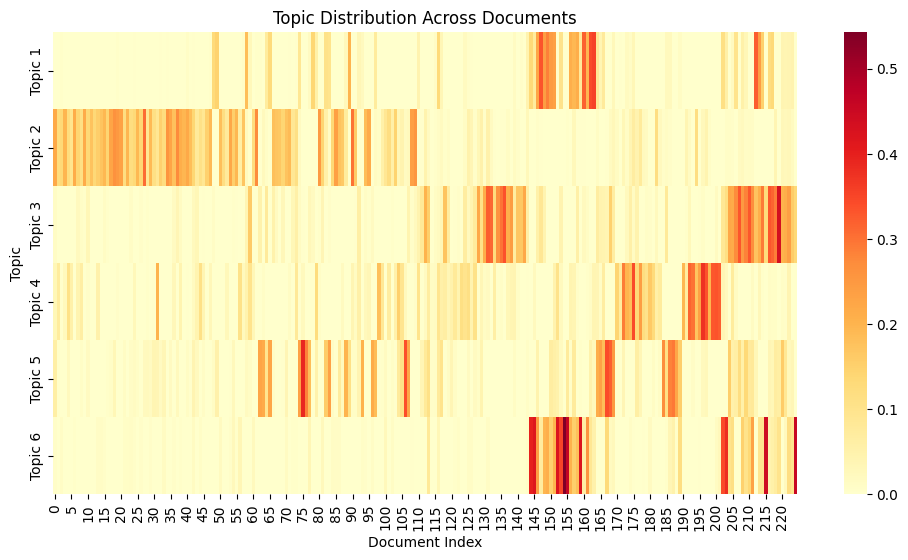

In [6]:
# Fit NMF with chosen number of topics
n_components = 6

nmf = NMF(n_components=n_components, random_state=42)
W = nmf.fit_transform(tfidf_matrix)
H = nmf.components_

nmf_embedding = (W - W.mean(axis=0))/W.std(axis=0)
nmf_embedding

# Get top terms for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10
topic_terms = []

for topic_idx, topic in enumerate(H):
    top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    topic_terms.append(top_terms)

# Create topic distribution heatmap
topic_dist = pd.DataFrame(W)
topic_dist.columns = [f"Topic {i+1}" for i in range(n_components)]

plt.figure(figsize=(12, 6))
sns.heatmap(topic_dist.T, cmap="YlOrRd")
plt.title("Topic Distribution Across Documents")
plt.xlabel("Document Index")
plt.ylabel("Topic")

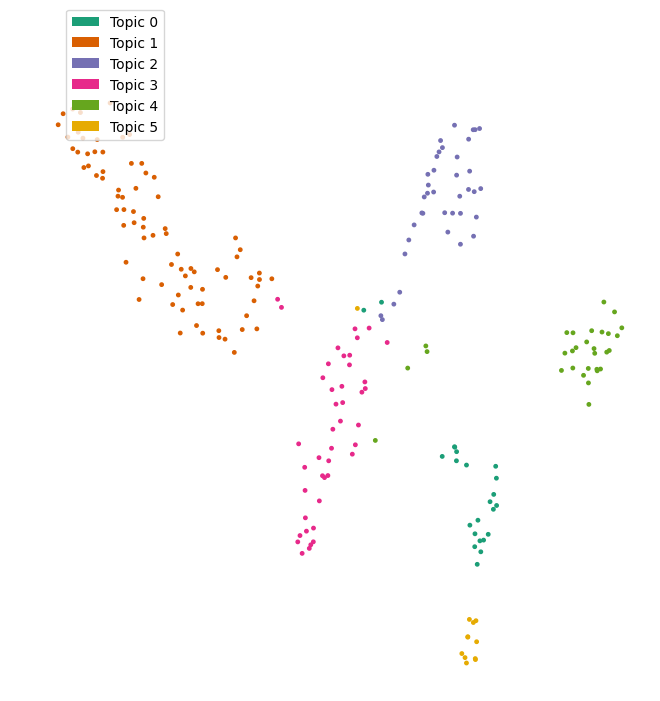

In [7]:
colormap = "Dark2"

# make a t-SNE embedding
tsne = TSNE()#pass in int random_state for deterministic behavior
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])

# get the colors to put in the legend
cmap = plt.cm.get_cmap(colormap)
color_list = cmap(range(0, n_components))
legend_list, topics = [], []
for i in range(n_components): 
    legend_list.append(mpatches.Ellipse((0,0), 1, 1, fc=color_list[i]))
    topics.append("Topic "+str(i))
# now force these colors to be used in the plot
tsne_color = []
for i in nmf_embedding.argmax(axis=1): tsne_color.append(color_list[i])
tsne_embedding = tsne_embedding.assign(color= tsne_color)

# plot!
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.axis('off')
ax.scatter(x=tsne_embedding['x'], y=tsne_embedding['y'], s=6, c=tsne_embedding['color'])
fig.legend(legend_list, topics, loc=(0.1, 0.8))

In [8]:
words = vectorizer.get_feature_names_out()
for index, topic in enumerate(nmf.components_):
    print(f"Topic {index}:")
    print([words[i] for i in topic.argsort()[-10:]])

Topic 0:
['lchedy', 'qokeey', 'qotedy', 'ol', 'otedy', 'okedy', 'qokeedy', 'chedy', 'qokedy', 'shedy']
Topic 1:
['shy', 'shor', 'cthor', 'sho', 'chy', 'shol', 'cthy', 'chor', 'chol', 'daiin']
Topic 2:
['air', 'oteedy', 'qokaiin', 'okaiin', 'okeey', 'oteey', 'otaiin', 'aiin', 'ar', 'al']
Topic 3:
['okeey', 'ckhey', 'chol', 'cheor', 'qokeol', 'or', 'cheol', 'daiin', 'ol', 'okeol']
Topic 4:
['ol', 'dar', 'okaiin', 'chedy', 'qokar', 'ar', 'okar', 'chdy', 'aiin', 'or']
Topic 5:
['qokeey', 'chey', 'okain', 'qokal', 'chedy', 'qol', 'shey', 'ol', 'shedy', 'qokain']


In [9]:
topic_distribution = pd.DataFrame(W, columns=[f"Topic {i+1}" for i in range(n_components)], index=vms_mapping)
topic_distribution

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
f1r,0.000000,0.219930,0.011129,0.032501,0.060969,0.007090
f1v,0.000029,0.124076,0.000000,0.072560,0.006219,0.000000
f2r,0.006294,0.134416,0.000000,0.003231,0.000000,0.011433
f2v,0.000000,0.198370,0.000666,0.023881,0.000000,0.000000
f3r,0.000000,0.124360,0.000000,0.106230,0.021971,0.000000
...,...,...,...,...,...,...
f114r,0.042172,0.030898,0.202614,0.009139,0.158478,0.000000
f114v,0.038863,0.026307,0.211710,0.008130,0.086522,0.022005
f115r,0.041396,0.030022,0.238955,0.040759,0.025599,0.117734
f115v,0.044562,0.020810,0.158272,0.000000,0.035623,0.097442


In [10]:
davis_df = pd.read_csv("data/davis_attribution.csv", index_col="folio")
davis_df

,topic,hand,language,quire
folio,,,,
f1r,botanical,1,a,1
f1v,botanical,1,a,1
f2r,botanical,1,a,1
f2v,botanical,1,a,1
f3r,botanical,1,a,1
...,...,...,...,...
f114r,starred paragraphs,3,b,18
f114v,starred paragraphs,3,b,18
f115r,starred paragraphs,3,b,18


In [11]:
dominant_topics = np.argmax(W, axis=1)

In [12]:
metadata_df = davis_df.copy()[["language", "topic", "hand"]]
metadata_df["topic_nmf"] = dominant_topics

metadata_df

,language,topic,hand,topic_nmf
folio,,,,
f1r,a,botanical,1,1
f1v,a,botanical,1,1
f2r,a,botanical,1,1
f2v,a,botanical,1,1
f3r,a,botanical,1,1
...,...,...,...,...
f114r,b,starred paragraphs,3,2
f114v,b,starred paragraphs,3,2
f115r,b,starred paragraphs,3,2


In [13]:
mca = MCA(n_components=n_components, copy=True, check_input=True, random_state=42)
mca = mca.fit(metadata_df)

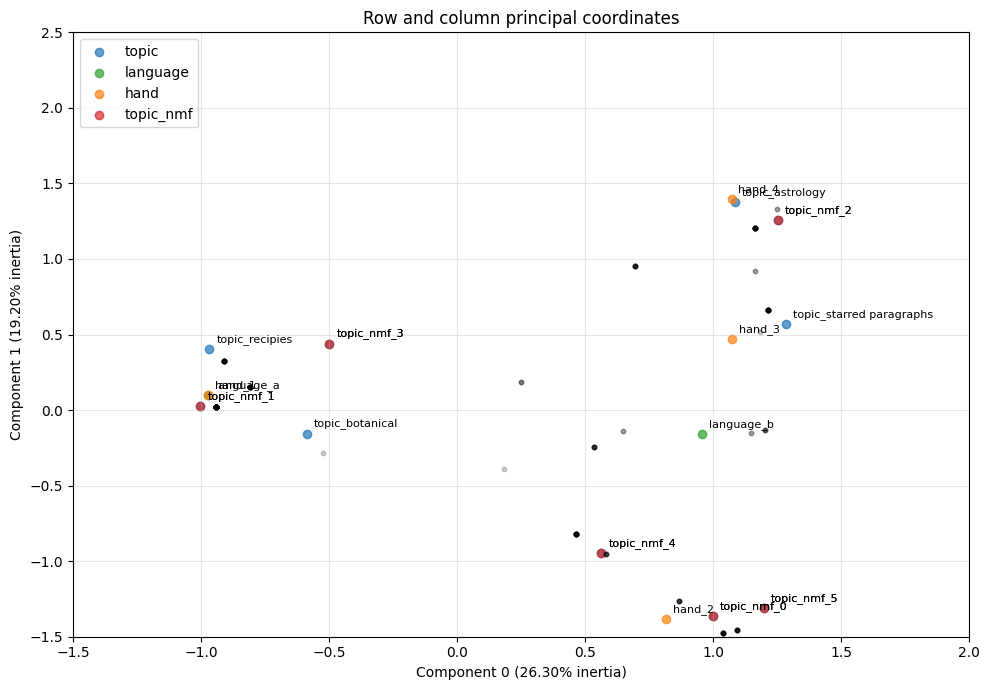

In [14]:
mca_coords = mca.fit(metadata_df)

# Get coordinates for rows and columns
row_coords = mca.row_coordinates(metadata_df)
col_coords = mca.column_coordinates(metadata_df)

eigenvalues = mca.eigenvalues_
total_inertia = np.sum(eigenvalues)
explained_inertia = [val/total_inertia for val in eigenvalues]

plt.figure(figsize=(10, 7))
    
    # Plot settings
plt.grid(True, alpha=0.3)

# Define colors for each category
category_colors = {
    "topic": "#1f77b4",      # blue
    "language": "#2ca02c",   # green
    "hand": "#ff7f0e",       # orange
    "topic_nmf": "#d62728"   # red
}

# Plot column coordinates with different colors for each category
for category in ["topic", "language", "hand", "topic_nmf"]:
    # Filter coordinates for the current category
    mask = col_coords.index.str.startswith(category)
    points = col_coords[mask]
    
    # Plot points
    plt.scatter(
        points[0],
        points[1],
        c=category_colors[category],
        label=category,
        alpha=0.7
    )
    
    # Add annotations
    for idx, coord in points.iterrows():
        plt.annotate(
            idx,
            (coord[0], coord[1]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8
        )

# Plot row coordinates as small black dots
plt.scatter(
    row_coords[0],
    row_coords[1],
    c="black",
    s=10,
    alpha=0.2
)

# Add title and labels
plt.title("Row and column principal coordinates")
plt.xlabel(f"Component 0 ({explained_inertia[0]:.2%} inertia)")
plt.ylabel(f"Component 1 ({explained_inertia[1]:.2%} inertia)")
plt.xlim(-1.5, 2)
plt.ylim(-1.5, 2.5)

# Add legend
plt.legend(loc="upper left")

# Adjust layout
plt.tight_layout()

## Figure 9

In [28]:
index, corpus = tokenize(fpath, word_limit=40)
arr = [index[k] for k in index.keys()]

vectorizer = TfidfVectorizer(max_df=0.95)
tfidf_matrix = vectorizer.fit_transform(arr)
vms_mapping = [k for k in index.keys()]

Text(120.72222222222221, 0.5, 'Topic')

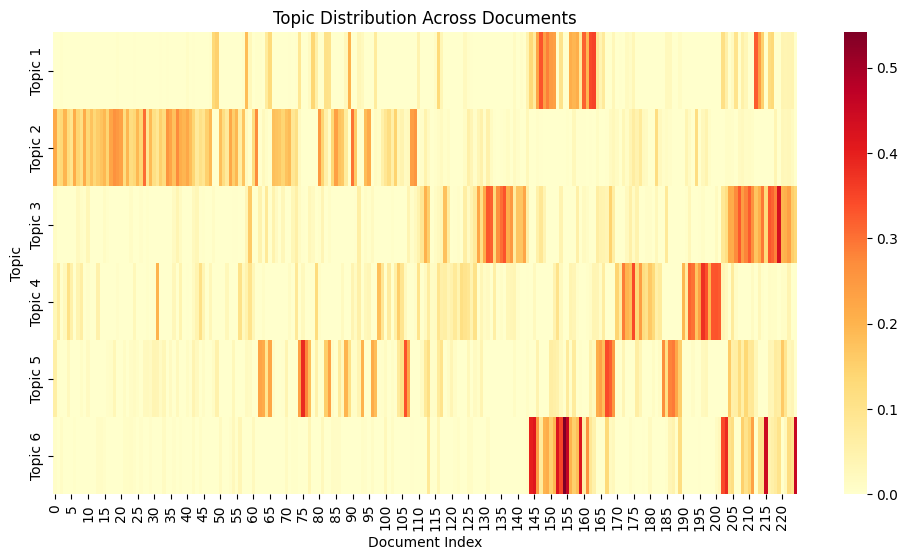

In [29]:
n_components = 6

nmf = NMF(n_components=n_components, random_state=42)
W = nmf.fit_transform(tfidf_matrix)
H = nmf.components_

# Get top terms for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10
topic_terms = []

for topic_idx, topic in enumerate(H):
    top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    topic_terms.append(top_terms)

# Create topic distribution heatmap
topic_dist = pd.DataFrame(W)
topic_dist.columns = [f"Topic {i+1}" for i in range(n_components)]

plt.figure(figsize=(12, 6))
sns.heatmap(topic_dist.T, cmap="YlOrRd")
plt.title("Topic Distribution Across Documents")
plt.xlabel("Document Index")
plt.ylabel("Topic")

In [30]:
dominant_topics = np.argmax(W, axis=1)
dominant_topics

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 2, 1, 1, 4, 4, 4, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 0, 3, 1, 1, 4, 4, 1, 1, 1, 1,
       4, 0, 1, 1, 2, 4, 1, 1, 4, 4, 3, 3, 1, 1, 1, 1, 3, 4, 4, 4, 1, 1,
       3, 2, 2, 2, 3, 3, 0, 4, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 0, 0, 0, 0, 0, 5, 5,
       5, 5, 0, 0, 0, 5, 0, 5, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 5])

In [31]:
metadata_df = davis_df.copy()[["language", "topic", "hand"]]
metadata_df["topic_nmf"] = dominant_topics

metadata_df

,language,topic,hand,topic_nmf
folio,,,,
f1r,a,botanical,1,1
f1v,a,botanical,1,1
f2r,a,botanical,1,1
f2v,a,botanical,1,1
f3r,a,botanical,1,1
...,...,...,...,...
f114r,b,starred paragraphs,3,2
f114v,b,starred paragraphs,3,2
f115r,b,starred paragraphs,3,2


In [32]:
mca = MCA(n_components=n_components, copy=True, check_input=True, random_state=42)
mca = mca.fit(metadata_df)

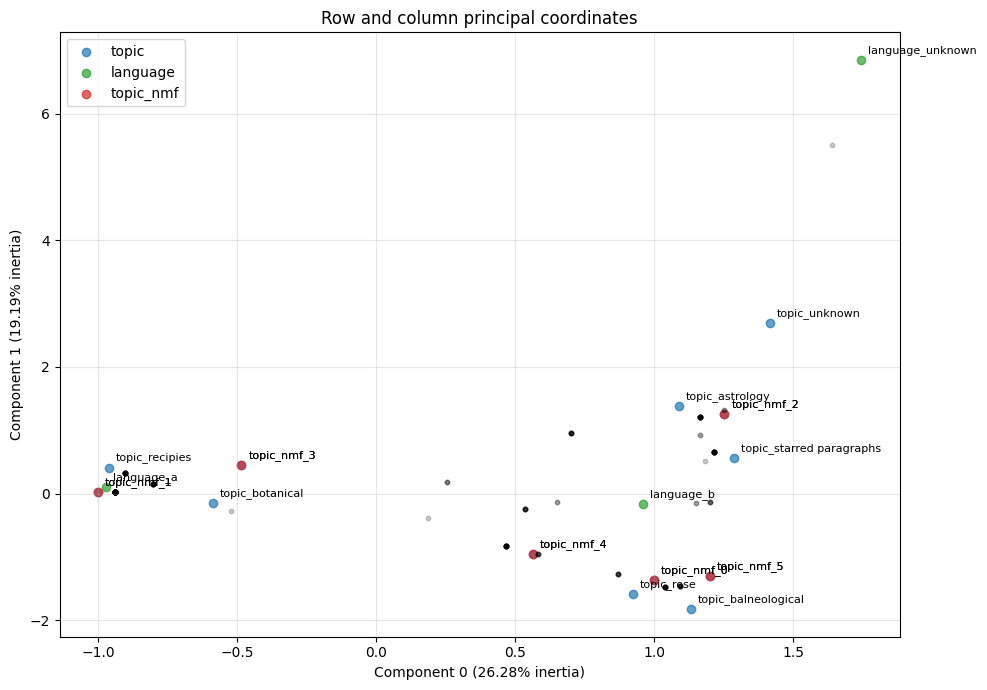

In [33]:
# Get coordinates for rows and columns
row_coords = mca.row_coordinates(metadata_df)
col_coords = mca.column_coordinates(metadata_df)

eigenvalues = mca.eigenvalues_
total_inertia = np.sum(eigenvalues)
explained_inertia = [val/total_inertia for val in eigenvalues]

plt.figure(figsize=(10, 7))
plt.grid(True, alpha=0.3)

# Define colors for each category
category_colors = {
    "topic": "#1f77b4",      # blue
    "language": "#2ca02c",   # green
    "hand": "#ff7f0e",       # orange
    "topic_nmf": "#d62728"   # red
}

# Plot column coordinates with different colors for each category
for category in ["topic", "language", "topic_nmf"]:
    # Filter coordinates for the current category
    mask = col_coords.index.str.startswith(category)
    points = col_coords[mask]
    
    # Plot points
    plt.scatter(
        points[0],
        points[1],
        c=category_colors[category],
        label=category,
        alpha=0.7
    )
    
    # Add annotations
    for idx, coord in points.iterrows():
        plt.annotate(
            idx,
            (coord[0], coord[1]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8
        )

# Plot row coordinates as small black dots
plt.scatter(
    row_coords[0],
    row_coords[1],
    c="black",
    s=10,
    alpha=0.2
)

# Add title and labels
plt.title("Row and column principal coordinates")
plt.xlabel(f"Component 0 ({explained_inertia[0]:.2%} inertia)")
plt.ylabel(f"Component 1 ({explained_inertia[1]:.2%} inertia)")
# plt.xlim(-1, 1.5)
# plt.ylim(-1, 3.0)

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

## Figure 11

In [34]:
index, corpus = tokenize(fpath, word_limit=20)
arr = [index[k] for k in index.keys()]

vectorizer = TfidfVectorizer(max_df=0.95)
tfidf_matrix = vectorizer.fit_transform(arr)
vms_mapping = [k for k in index.keys()]

Text(120.72222222222221, 0.5, 'Topic')

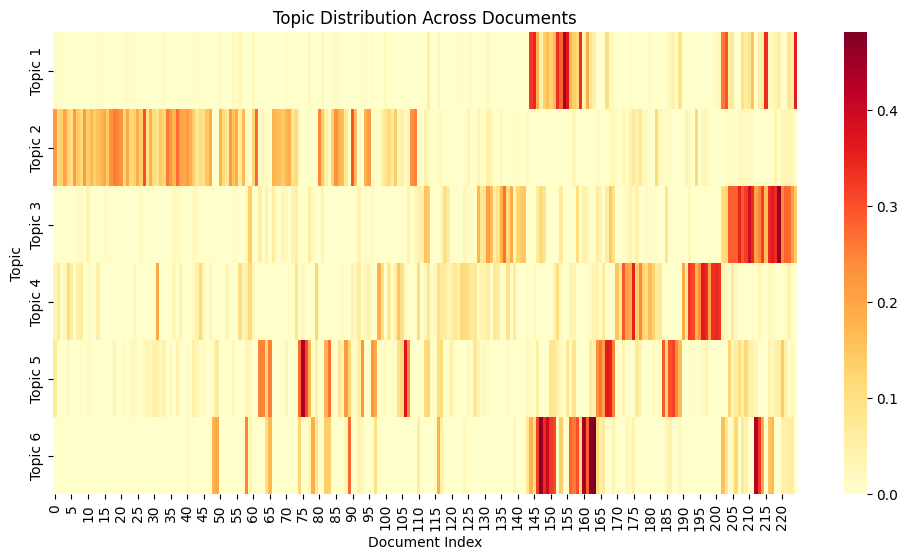

In [35]:
n_components = 6

nmf = NMF(n_components=n_components, random_state=42)
W = nmf.fit_transform(tfidf_matrix)
H = nmf.components_

# Get top terms for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10
topic_terms = []

for topic_idx, topic in enumerate(H):
    top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    topic_terms.append(top_terms)

# Create topic distribution heatmap
topic_dist = pd.DataFrame(W)
topic_dist.columns = [f"Topic {i+1}" for i in range(n_components)]

plt.figure(figsize=(12, 6))
sns.heatmap(topic_dist.T, cmap="YlOrRd")
plt.title("Topic Distribution Across Documents")
plt.xlabel("Document Index")
plt.ylabel("Topic")

In [36]:
dominant_topics = np.argmax(W, axis=1)
dominant_topics

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 3, 1, 5, 2, 1, 1, 4, 4, 4, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 5, 3, 1, 1, 4, 4, 1, 1, 1, 1,
       4, 5, 1, 1, 3, 4, 1, 1, 4, 4, 3, 3, 1, 1, 1, 1, 3, 4, 4, 4, 1, 1,
       3, 2, 2, 2, 3, 3, 5, 4, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 0, 0, 5, 5, 5, 5, 5, 5, 0, 0,
       0, 0, 5, 5, 5, 0, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0])

In [37]:
metadata_df = davis_df.copy()[["language", "topic", "hand"]]
metadata_df["topic_nmf"] = dominant_topics

metadata_df

,language,topic,hand,topic_nmf
folio,,,,
f1r,a,botanical,1,1
f1v,a,botanical,1,1
f2r,a,botanical,1,1
f2v,a,botanical,1,1
f3r,a,botanical,1,1
...,...,...,...,...
f114r,b,starred paragraphs,3,2
f114v,b,starred paragraphs,3,2
f115r,b,starred paragraphs,3,2


In [38]:
mca = MCA(n_components=n_components, copy=True, check_input=True, random_state=42)
mca = mca.fit(metadata_df)

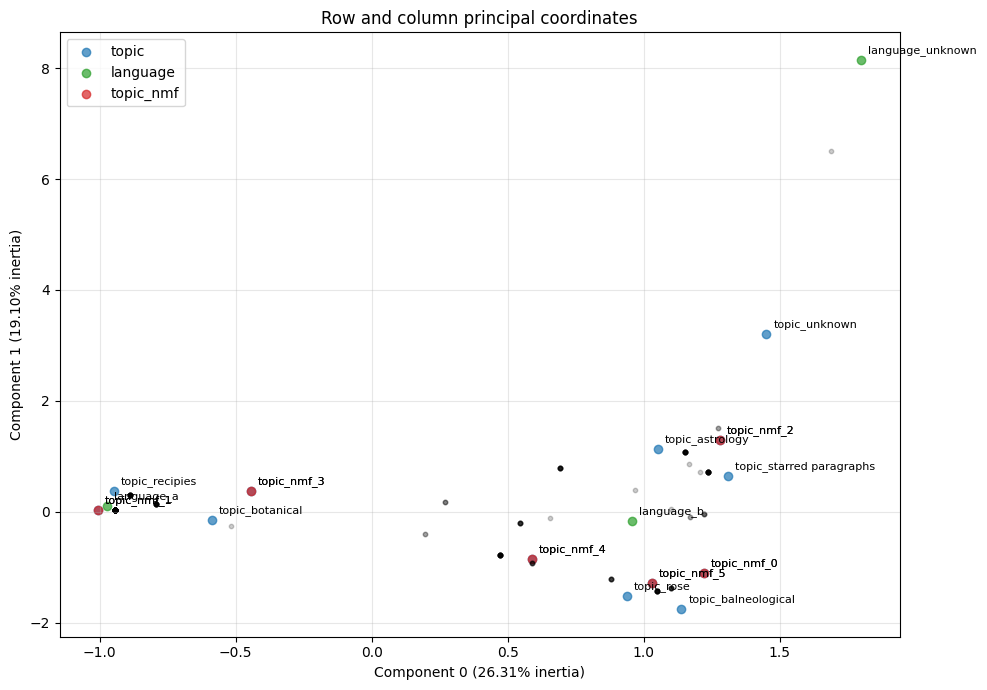

In [39]:
# Get coordinates for rows and columns
row_coords = mca.row_coordinates(metadata_df)
col_coords = mca.column_coordinates(metadata_df)

eigenvalues = mca.eigenvalues_
total_inertia = np.sum(eigenvalues)
explained_inertia = [val/total_inertia for val in eigenvalues]

plt.figure(figsize=(10, 7))
plt.grid(True, alpha=0.3)

# Define colors for each category
category_colors = {
    "topic": "#1f77b4",      # blue
    "language": "#2ca02c",   # green
    "hand": "#ff7f0e",       # orange
    "topic_nmf": "#d62728"   # red
}

# Plot column coordinates with different colors for each category
for category in ["topic", "language", "topic_nmf"]:
    # Filter coordinates for the current category
    mask = col_coords.index.str.startswith(category)
    points = col_coords[mask]
    
    # Plot points
    plt.scatter(
        points[0],
        points[1],
        c=category_colors[category],
        label=category,
        alpha=0.7
    )
    
    # Add annotations
    for idx, coord in points.iterrows():
        plt.annotate(
            idx,
            (coord[0], coord[1]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8
        )

# Plot row coordinates as small black dots
plt.scatter(
    row_coords[0],
    row_coords[1],
    c="black",
    s=10,
    alpha=0.2
)

# Add title and labels
plt.title("Row and column principal coordinates")
plt.xlabel(f"Component 0 ({explained_inertia[0]:.2%} inertia)")
plt.ylabel(f"Component 1 ({explained_inertia[1]:.2%} inertia)")
# plt.xlim(-1, 1.5)
# plt.ylim(-1, 3.0)

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

## Bible

In [116]:
voynich = "/Users/katecastillo/Documents/MSDS/voynich-manuscript/takahashi_transcription.txt"

index, corpus = tokenize(voynich)
voynich_documents = [index[k] for k in index.keys()]

In [117]:
bible_sp = "/Users/katecastillo/Documents/MSDS/voynich-manuscript/data/bible_sp.txt"

index, corpus = tokenize_bible_sp(bible_sp)
spanish_bible = [index[k] for k in index.keys()]

In [118]:
bible_en = "/Users/katecastillo/Documents/MSDS/voynich-manuscript/data/bible_en.txt"

index, corpus = tokenize_bible_en(bible_en)
english_bible = [index[k] for k in index.keys()]

In [182]:
def calculate_pmi(verse_text):
    full_text = ' '.join(verse_text)
    
    # Create and fit vectorizers for both unigrams and bigrams
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
    trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
    
    # Get bigram frequencies
    bigram_vec = bigram_vectorizer.fit_transform([full_text])
    bigram_vocab = bigram_vectorizer.get_feature_names_out()
    bigram_freq = np.asarray(bigram_vec.sum(axis=0)).flatten()
    
    # Get trigram frequencies
    trigram_vec = trigram_vectorizer.fit_transform([full_text])
    trigram_freq = np.asarray(trigram_vec.sum(axis=0)).flatten()
    
    # Create dictionaries for both trigrams and bigrams
    bigram_counts = dict(zip(bigram_vocab, bigram_freq))
    trigram_counts = dict(zip(trigram_vectorizer.get_feature_names_out(), trigram_freq))
    
    # Convert to Counter objects
    bigram_counter = Counter({k: int(v) for k, v in bigram_counts.items()})
    trigram_counter = Counter({k: int(v) for k, v in trigram_counts.items()})
    
    # Calculate total counts
    total_bigrams = sum(bigram_counter.values())
    total_trigrams = sum(trigram_counter.values())
    
    # Calculate PMI scores
    pmi_scores = {}
    for bigram in bigram_vocab:
        # Split bigram into first two words of potential trigram
        word1, word2 = bigram.split()
        
        # Calculate base probabilities for bigram
        p_xy = bigram_counter[bigram] / total_bigrams
        
        # Find all trigrams that start with this bigram
        matching_trigrams = {k: v for k, v in trigram_counter.items() 
                           if k.startswith(f"{word1} {word2}")}
        
        for trigram, count in matching_trigrams.items():
            # Calculate probabilities
            p_xyz = count / total_trigrams
            
            # Calculate PMI if all probabilities are positive
            if p_xyz > 0 and p_xy > 0:
                pmi_scores[trigram] = log(p_xyz / p_xy, 2)
    
    return pmi_scores, bigram_counter, trigram_counter

In [ ]:
voynich_pmi_scores, voynich_bigram_counts, voynich_unigram_counts = calculate_pmi(voynich_documents)
english_pmi_scores, english_bigram_counts, english_unigram_counts = calculate_pmi(english_bible)
spanish_pmi_scores, spanish_bigram_counts, spanish_unigram_counts = calculate_pmi(spanish_bible)

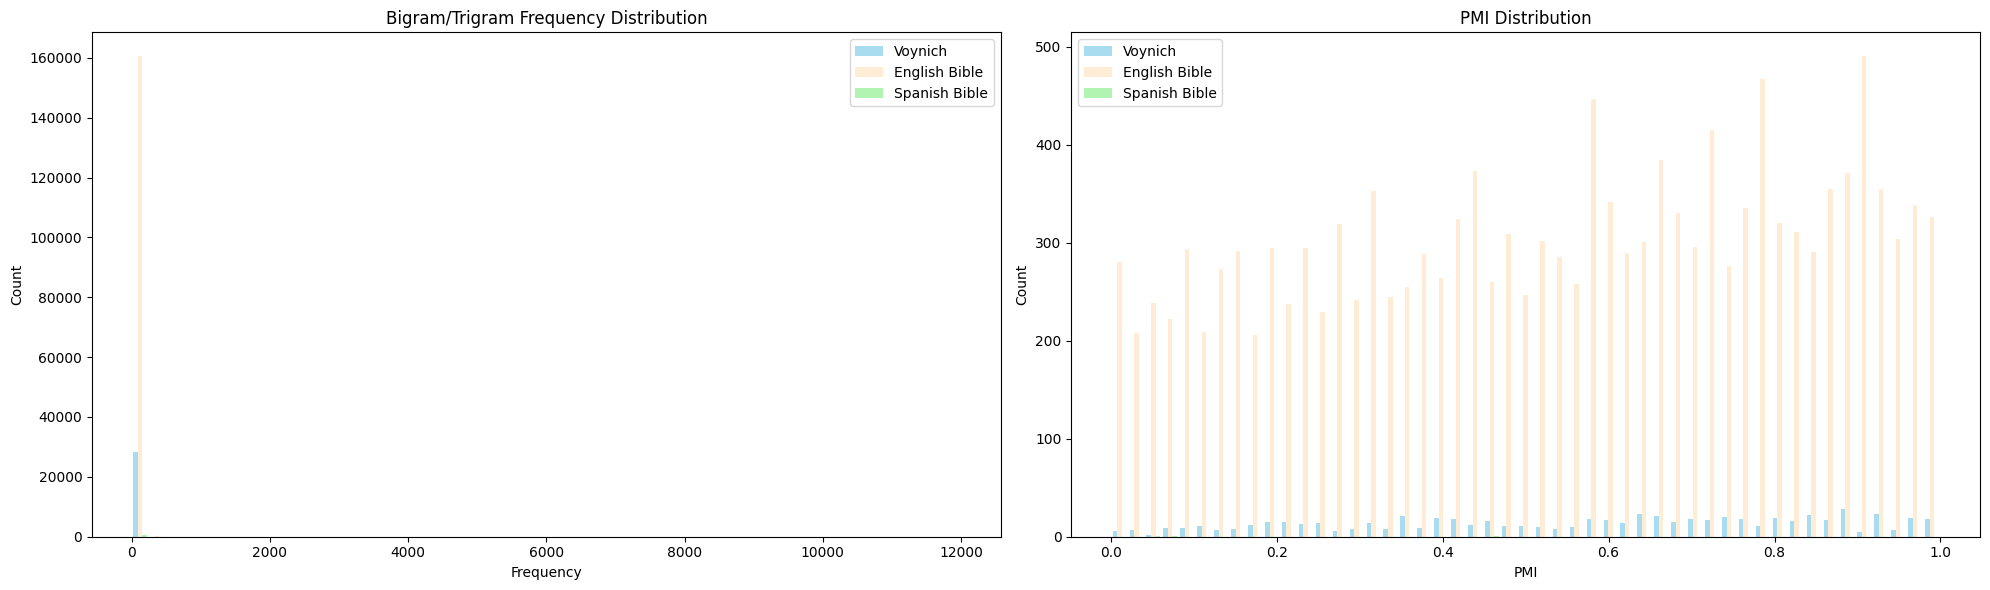

In [188]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First subplot - Bigram/Trigram Frequency Distribution
ax1.set_title("Bigram/Trigram Frequency Distribution")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Count")

bin_edges = np.linspace(0, 12000, 50)
ax1.hist([list(voynich_bigram_counts.values()),
          list(english_bigram_counts.values()),
          list(spanish_bigram_counts.values())],
         bins=bin_edges, 
         label=["Voynich", "English Bible", "Spanish Bible"],
         color=["skyblue", "bisque", "lightgreen"],
         alpha=0.7)

ax1.legend()

# Second subplot - PMI Distribution
ax2.set_title("PMI Distribution")
ax2.set_xlabel("PMI")
ax2.set_ylabel("Count")

pmi_bin_edges = np.linspace(0, 1, 50)
ax2.hist([list(voynich_pmi_scores.values()),
          list(english_pmi_scores.values()),
          list(spanish_pmi_scores.values())],
         bins=pmi_bin_edges,
         label=["Voynich", "English Bible", "Spanish Bible"],
         color=["skyblue", "bisque", "lightgreen"],
         alpha=0.7)

ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Cosine Similarity

In [194]:
voynich = "/Users/katecastillo/Documents/MSDS/voynich-manuscript/takahashi_transcription.txt"

index, corpus = tokenize(voynich)
voynich_documents = [index[k] for k in index.keys()]

index

defaultdict(str,
            {'f1r': 'fachys ykal ar ataiin shol shory cthres y kor sholdysory ckhar or y kair chtaiin shar are cthar cthar dansyaiir sheky or ykaiin shod cthoary cthes daraiin saooiin oteey oteos roloty cth*ar daiin otaiin or okandair y chear cthaiin cphar cfhaiinydaraishy* odar o y shol cphoy oydar sh s cfhoaiin shodaryyshey shody okchoy otchol chocthy oschy dain chor kosdaiin shos cfhol shodydain os teody* ydain cphesaiin ol s cphey ytain shoshy cphodalesoksho kshoy otairin oteol okan shodain sckhey daiinshoy ckhey kodaiin cphy cphodaiils cthey she oldain ddain oiin chol odaiin chodain chdy okain dan cthy koddaiin shckhey ckeor chor shey kol chol chol kor chalsho chol shodan kshy kchy dor chodaiin sho kchomycho tchey chokain sheo pshol dydyd cthy daicthyyto shol she kodshey cphealy dasain dain ckhydsdchar shcthaiin okaiir chey rchy potol cthols dloctashok chor chey dain ckheyotol daiiincpho shaiin shokcheey chol tshodeesy shey pydeey chy ro d**doin chol dain cthal da

In [223]:
from sklearn.metrics.pairwise import cosine_similarity

def load_and_preprocess_folios(text_data):
    """
    Prepare folio text data for analysis.
    Args:
        text_data (dict): Dictionary with folio numbers as keys and text content as values
    Returns:
        DataFrame: Processed folio texts with labels
    """
    # Convert to DataFrame for easier handling
    df = pd.DataFrame(list(text_data.items()), columns=["folio", "text"])
    df.folio = df.folio.str.extract(r"f(\d+)*").astype(int)
    
    # Add section labels based on folio numbers
    conditions = [
        (df["folio"] <= 60),
        (df["folio"].between(61, 74)),
        (df["folio"].between(75, 84)),
        (df["folio"].between(85, 90)),
        (df["folio"] >= 91)
    ]
    sections = ["Herbal", "Astro", "Bio", "Pharma", "Recipes"]
    df["section"] = np.select(conditions, sections, default="Unknown")
    
    return df

def calculate_similarity_matrix(texts):
    """
    Calculate cosine similarity matrix for the given texts.
    Args:
        texts (list): List of text strings to compare
    Returns:
        ndarray: Similarity matrix
    """
    vectorizer = CountVectorizer(analyzer="char", ngram_range=(2, 3))
    text_matrix = vectorizer.fit_transform(texts)
    similarity_matrix = cosine_similarity(text_matrix)
    return similarity_matrix

def plot_similarity_heatmap(similarity_matrix, folio_labels, sections, output_file="voynich_similarity.png"):
    """
    Create heatmap with improved tick labels and reversed y-axis
    """
    plt.figure(figsize=(15, 12))
    
    # Create the heatmap with reversed y-axis
    ax = sns.heatmap(
        similarity_matrix,
        cmap="YlOrRd",
        vmin=0,
        vmax=1,
        center=0.5,
        xticklabels=10,  # Show every 10th label
        yticklabels=10,
        square=True
    )
    
    # Get total number of folios
    n_folios = len(folio_labels)
    
    # Create tick positions - show every 10th folio
    tick_positions = np.arange(0, n_folios, 10)
    tick_labels = [folio_labels[i] for i in tick_positions]
    
    # Set tick parameters
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")
    ax.set_yticklabels(reversed(tick_labels), rotation=0)  # Reverse y-axis labels
    
    # Add section boundaries
    section_boundaries = [0]
    current_section = sections[0]
    for i, section in enumerate(sections[1:], 1):
        if section != current_section:
            plt.axhline(y=i, color="black", linewidth=1)
            plt.axvline(x=i, color="black", linewidth=1)
            section_boundaries.append(i)
            current_section = section
    
    # Add title and labels
    plt.title("Voynich Manuscript Folio Similarity Matrix", pad=20)
    plt.xlabel("Folio Number", labelpad=10)
    plt.ylabel("Folio Number", labelpad=10)
    
    # Invert y-axis
    ax.invert_yaxis()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save plot
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()

In [224]:
# Process data
df = load_and_preprocess_folios(index)

# Calculate similarity matrix
similarity_matrix = calculate_similarity_matrix(df["text"])

# Create visualization
plot_similarity_heatmap(
    similarity_matrix,
    df["folio"],
    df["section"],
    "voynich_similarity.png"
)

# Print summary statistics
print("Average similarity by section:")
for section in df["section"].unique():
    mask = df["section"] == section
    section_similarities = similarity_matrix[mask][:, mask]
    print(f"{section}: {np.mean(section_similarities):.3f}")

Average similarity by section:
Herbal: 0.729
Astro: 0.744
Bio: 0.928
Pharma: 0.792
Recipes: 0.789
